# Audio Denoising Using Deep Learning :  Noise2Noise Approach #

### Enter the noise type you want to train the model to denoise. The test and train dataset must already be generated beforehand. ###

In [1]:
noise_class = "white" 

### Specify the type of training you want to employ: either "Noise2Noise"  ###

In [2]:
training_type =  "Noise2Noise" 

### Import of libraries ###

In [3]:
from pathlib import Path

if noise_class == "white": 
    TRAIN_INPUT_DIR = Path('Datasets/WhiteNoise_Train_Input')

    if training_type == "Noise2Noise":
        TRAIN_TARGET_DIR = Path('Datasets/WhiteNoise_Train_Output')
    elif training_type == "Noise2Clean":
        TRAIN_TARGET_DIR = Path('Datasets/clean_trainset_28spk_wav')
    else:
        raise Exception("Enter valid training type")

    TEST_NOISY_DIR = Path('Datasets/WhiteNoise_Test_Input')
    TEST_CLEAN_DIR = Path('Datasets/clean_testset_wav') 
    
else:
    TRAIN_INPUT_DIR = Path('Datasets/US_Class'+str(noise_class)+'_Train_Input')

    if training_type == "Noise2Noise":
        TRAIN_TARGET_DIR = Path('Datasets/US_Class'+str(noise_class)+'_Train_Output')
    elif training_type == "Noise2Clean":
        TRAIN_TARGET_DIR = Path('Datasets/clean_trainset_28spk_wav')
    else:
        raise Exception("Enter valid training type")

    TEST_NOISY_DIR = Path('Datasets/US_Class'+str(noise_class)+'_Test_Input')
    TEST_CLEAN_DIR = Path('Datasets/clean_testset_wav') 

In [4]:
import os
basepath = str(noise_class)+"_"+training_type
os.makedirs(basepath,exist_ok=True)
os.makedirs(basepath+"/Weights",exist_ok=True)
os.makedirs(basepath+"/Samples",exist_ok=True)

In [5]:
!nvcc --version  

'nvcc' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
import time
import pickle
import warnings
import gc
import copy

import noise_addition_utils

from metrics import AudioMetrics
from metrics import AudioMetrics2

import numpy as np
import torch
import torch.nn as nn
import torchaudio

from tqdm import tqdm, tqdm_notebook
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
from pypesq import pesq
from IPython.display import clear_output

%matplotlib inline

# not everything is smooth in sklearn, to conveniently output images in colab
# we will ignore warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

C:\Users\HP\anaconda3\envs\audio_denoiser\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [7]:
print(torch.cuda.device_count()) 

0


In [8]:
np.random.seed(999)
torch.manual_seed(999)

# If running on Cuda set these 2 for determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Checking whether the GPU is available ###

In [9]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')
       
DEVICE = torch.device('cuda' if train_on_gpu else 'cpu')

No GPU available, training on CPU.


In [10]:
!nvidia-smi

Sat Feb  8 11:27:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8              2W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Set Audio backend as Soundfile for windows and Sox for Linux ###

In [11]:
torchaudio.set_audio_backend("soundfile")
print("TorchAudio backend used:\t{}".format(torchaudio.get_audio_backend()))

TorchAudio backend used:	soundfile


### The sampling frequency and the selected values for the Short-time Fourier transform. ###

In [12]:
SAMPLE_RATE = 48000
N_FFT = (SAMPLE_RATE * 64) // 1000 
HOP_LENGTH = (SAMPLE_RATE * 16) // 1000 

### The declaration of datasets and dataloaders ###

In [13]:
class SpeechDataset(Dataset):
    """
    A dataset class with audio that cuts them/paddes them to a specified length, applies a Short-tome Fourier transform,
    normalizes and leads to a tensor.
    """
    def __init__(self, noisy_files, clean_files, n_fft=64, hop_length=16):
        super().__init__()
        # list of files
        self.noisy_files = sorted(noisy_files)
        self.clean_files = sorted(clean_files)
        
        # stft parameters
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        self.len_ = len(self.noisy_files)
        
        # fixed len
        self.max_len = 165000

    
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        waveform, _ = torchaudio.load(file)
        return waveform
  
    def __getitem__(self, index):
        # load to tensors and normalization
        x_clean = self.load_sample(self.clean_files[index])
        x_noisy = self.load_sample(self.noisy_files[index])
        
        # padding/cutting
        x_clean = self._prepare_sample(x_clean)
        x_noisy = self._prepare_sample(x_noisy)
        
        # Short-time Fourier transform
        x_noisy_stft = torch.stft(input=x_noisy, n_fft=self.n_fft, 
                                  hop_length=self.hop_length, normalized=True)
        x_clean_stft = torch.stft(input=x_clean, n_fft=self.n_fft, 
                                  hop_length=self.hop_length, normalized=True)
        
        return x_noisy_stft, x_clean_stft
        
#     def _prepare_sample(self, waveform):
#         waveform = waveform.numpy()
#         current_len = waveform.shape[1]
        
#         output = np.zeros((1, self.max_len), dtype='float32')
#         output[0, -current_len:] = waveform[0, :self.max_len]
#         output = torch.from_numpy(output)
        
#         return output

    def _prepare_sample(self, waveform, save_dir="Samples/Sample_Test_Input"):
        waveform = waveform.numpy()
        current_len = waveform.shape[1]

    # Initialize a zero-padded array
        output = np.zeros((1, self.max_len), dtype='float32')

        if current_len > self.max_len:
        # Save the remaining signal instead of discarding
            remaining_signal = waveform[:, self.max_len:]

        # Ensure save directory exists
            os.makedirs(save_dir, exist_ok=True)

        # Always save as "remaining_part.wav"
            remaining_filename = os.path.join(save_dir, "!!remaining_part.wav")

        # Convert NumPy array back to Torch tensor before saving
        # Ensure the signal is 2D (add channel dimension if needed)
            remaining_signal_tensor = torch.from_numpy(remaining_signal)

            if remaining_signal_tensor.ndimension() == 1:
            # If the tensor is 1D, add a channel dimension (for mono)
                remaining_signal_tensor = remaining_signal_tensor.unsqueeze(0)

        # Save the remaining part of the audio
            torchaudio.save(remaining_filename, remaining_signal_tensor, 48000)

        # Keep only the first `max_len` part in the output
            waveform = waveform[:, :self.max_len]

    # Copy the trimmed/padded waveform into the output array
        output[0, -current_len:] = waveform[0, :self.max_len]

    # Convert back to tensor
        output = torch.from_numpy(output)

        return output

In [14]:
train_input_files = sorted(list(TRAIN_INPUT_DIR.rglob('*.wav')))
train_target_files = sorted(list(TRAIN_TARGET_DIR.rglob('*.wav')))

test_noisy_files = sorted(list(TEST_NOISY_DIR.rglob('*.wav')))
test_clean_files = sorted(list(TEST_CLEAN_DIR.rglob('*.wav')))

print("No. of Training files:",len(train_input_files))
print("No. of Testing files:",len(test_noisy_files))

No. of Training files: 10
No. of Testing files: 8


In [15]:
test_dataset = SpeechDataset(test_noisy_files, test_clean_files, N_FFT, HOP_LENGTH)
train_dataset = SpeechDataset(train_input_files, train_target_files, N_FFT, HOP_LENGTH)

In [16]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# For testing purpose
test_loader_single_unshuffled = DataLoader(test_dataset, batch_size=1, shuffle=False)


### Average Test Set Metrics ###

In [17]:
def test_set_metrics(test_loader, model):
    metric_names = ["CSIG","CBAK","COVL","PESQ","SSNR","STOI"]
    overall_metrics = [[] for i in range(len(metric_names))]
    
    for i,(noisy,clean) in enumerate(test_loader):
        x_est = model(noisy.to(DEVICE), is_istft=True)
        x_est_np = x_est[0].view(-1).detach().cpu().numpy()
        x_c_np = torch.istft(torch.squeeze(clean[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()
        metrics = AudioMetrics(x_c_np, x_est_np, SAMPLE_RATE)
        
        overall_metrics[0].append(metrics.CSIG)
        overall_metrics[1].append(metrics.CBAK)
        overall_metrics[2].append(metrics.COVL)
        overall_metrics[3].append(metrics.PESQ)
        overall_metrics[4].append(metrics.SSNR)
        overall_metrics[5].append(metrics.STOI)
    
    metrics_dict = dict()
    for i in range(len(metric_names)):
        metrics_dict[metric_names[i]] ={'mean': np.mean(overall_metrics[i]), 'std_dev': np.std(overall_metrics[i])} 
    
    return metrics_dict

### Declaring the class layers ###

In [18]:
class CConv2d(nn.Module):
    """
    Class of complex valued convolutional layer
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        
        self.real_conv = nn.Conv2d(in_channels=self.in_channels, 
                                   out_channels=self.out_channels, 
                                   kernel_size=self.kernel_size, 
                                   padding=self.padding, 
                                   stride=self.stride)
        
        self.im_conv = nn.Conv2d(in_channels=self.in_channels, 
                                 out_channels=self.out_channels, 
                                 kernel_size=self.kernel_size, 
                                 padding=self.padding, 
                                 stride=self.stride)
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_conv.weight)
        nn.init.xavier_uniform_(self.im_conv.weight)
        
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        c_real = self.real_conv(x_real) - self.im_conv(x_im)
        c_im = self.im_conv(x_real) + self.real_conv(x_im)
        
        output = torch.stack([c_real, c_im], dim=-1)
        return output

In [19]:
class CConvTranspose2d(nn.Module):
    """
      Class of complex valued dilation convolutional layer
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding=0, padding=0):
        super().__init__()
        
        self.in_channels = in_channels

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.output_padding = output_padding
        self.padding = padding
        self.stride = stride
        
        self.real_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding,
                                            padding=self.padding,
                                            stride=self.stride)
        
        self.im_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding, 
                                            padding=self.padding,
                                            stride=self.stride)
        
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_convt.weight)
        nn.init.xavier_uniform_(self.im_convt.weight)
        
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        ct_real = self.real_convt(x_real) - self.im_convt(x_im)
        ct_im = self.im_convt(x_real) + self.real_convt(x_im)
        
        output = torch.stack([ct_real, ct_im], dim=-1)
        return output

In [20]:
class CBatchNorm2d(nn.Module):
    """
    Class of complex valued batch normalization layer
    """
    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True):
        super().__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        
        self.real_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                      affine=self.affine, track_running_stats=self.track_running_stats)
        self.im_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                    affine=self.affine, track_running_stats=self.track_running_stats) 
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        n_real = self.real_b(x_real)
        n_im = self.im_b(x_im)  
        
        output = torch.stack([n_real, n_im], dim=-1)
        return output

In [21]:
class Encoder(nn.Module):
    """
    Class of upsample block
    """
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45, padding=(0,0)):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = padding

        self.cconv = CConv2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconv(x)
        normed = self.cbn(conved)
        acted = self.leaky_relu(normed)
        
        return acted

In [22]:
class Decoder(nn.Module):
    """
    Class of downsample block
    """
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45,
                 output_padding=(0,0), padding=(0,0), last_layer=False):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_padding = output_padding
        self.padding = padding
        
        self.last_layer = last_layer
        
        self.cconvt = CConvTranspose2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, output_padding=self.output_padding, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconvt(x)
        
        if not self.last_layer:
            normed = self.cbn(conved)
            output = self.leaky_relu(normed)
        else:
            m_phase = conved / (torch.abs(conved) + 1e-8)
            m_mag = torch.tanh(torch.abs(conved))
            output = m_phase * m_mag
            
        return output

### Loss function ###

In [23]:
from pesq import pesq
from scipy import interpolate

def resample(original, old_rate, new_rate):
    if old_rate != new_rate:
        duration = original.shape[0] / old_rate
        time_old  = np.linspace(0, duration, original.shape[0])
        time_new  = np.linspace(0, duration, int(original.shape[0] * new_rate / old_rate))
        interpolator = interpolate.interp1d(time_old, original.T)
        new_audio = interpolator(time_new).T
        return new_audio
    else:
        return original


def wsdr_fn(x_, y_pred_, y_true_, eps=1e-8):
    # to time-domain waveform
    y_true_ = torch.squeeze(y_true_, 1)
    y_true = torch.istft(y_true_, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)
    x_ = torch.squeeze(x_, 1)
    x = torch.istft(x_, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)

    y_pred = y_pred_.flatten(1)
    y_true = y_true.flatten(1)
    x = x.flatten(1)


    def sdr_fn(true, pred, eps=1e-8):
        num = torch.sum(true * pred, dim=1)
        den = torch.norm(true, p=2, dim=1) * torch.norm(pred, p=2, dim=1)
        return -(num / (den + eps))

    # true and estimated noise
    z_true = x - y_true
    z_pred = x - y_pred

    a = torch.sum(y_true**2, dim=1) / (torch.sum(y_true**2, dim=1) + torch.sum(z_true**2, dim=1) + eps)
    wSDR = a * sdr_fn(y_true, y_pred) + (1 - a) * sdr_fn(z_true, z_pred)
    return torch.mean(wSDR)

wonky_samples = []

def getMetricsonLoader(loader, net, use_net=True):
    net.eval()
    # Original test metrics
    scale_factor = 32768
    # metric_names = ["CSIG","CBAK","COVL","PESQ","SSNR","STOI","SNR "]
    metric_names = ["PESQ-WB","PESQ-NB","SNR","SSNR","STOI"]
    overall_metrics = [[] for i in range(5)]
    for i, data in enumerate(loader):
        if (i+1)%10==0:
            end_str = "\n"
        else:
            end_str = ","
        #print(i,end=end_str)
        if i in wonky_samples:
            print("Something's up with this sample. Passing...")
        else:
            noisy = data[0]
            clean = data[1]
            if use_net: # Forward of net returns the istft version
                x_est = net(noisy.to(DEVICE), is_istft=True)
                x_est_np = x_est.view(-1).detach().cpu().numpy()
            else:
                x_est_np = torch.istft(torch.squeeze(noisy, 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()
            x_clean_np = torch.istft(torch.squeeze(clean, 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()
            
        
            metrics = AudioMetrics2(x_clean_np, x_est_np, 48000)
            
            ref_wb = resample(x_clean_np, 48000, 16000)
            deg_wb = resample(x_est_np, 48000, 16000)
            pesq_wb = pesq(16000, ref_wb, deg_wb, 'wb')
            
            ref_nb = resample(x_clean_np, 48000, 8000)
            deg_nb = resample(x_est_np, 48000, 8000)
            pesq_nb = pesq(8000, ref_nb, deg_nb, 'nb')

            #print(new_scores)
            #print(metrics.PESQ, metrics.STOI)

            overall_metrics[0].append(pesq_wb)
            overall_metrics[1].append(pesq_nb)
            overall_metrics[2].append(metrics.SNR)
            overall_metrics[3].append(metrics.SSNR)
            overall_metrics[4].append(metrics.STOI)
    print()
    print("Sample metrics computed")
    results = {}
    for i in range(5):
        temp = {}
        temp["Mean"] =  np.mean(overall_metrics[i])
        temp["STD"]  =  np.std(overall_metrics[i])
        temp["Min"]  =  min(overall_metrics[i])
        temp["Max"]  =  max(overall_metrics[i])
        results[metric_names[i]] = temp
    print("Averages computed")
    if use_net:
        addon = "(cleaned by model)"
    else:
        addon = "(pre denoising)"
    print("Metrics on test data",addon)
    for i in range(5):
        print("{} : {:.3f}+/-{:.3f}".format(metric_names[i], np.mean(overall_metrics[i]), np.std(overall_metrics[i])))
    return results

### Description of the training of epochs. ###

In [24]:
def train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    for noisy_x, clean_x in train_loader:

        noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)

        # zero  gradients
        net.zero_grad()

        # get the output from the model
        pred_x = net(noisy_x)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1

    train_ep_loss /= counter

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()
    return train_ep_loss

### Description of the validation of epochs ###

In [25]:
def test_epoch(net, test_loader, loss_fn, use_net=True):
    net.eval()
    test_ep_loss = 0.
    counter = 0.
    '''
    for noisy_x, clean_x in test_loader:
        # get the output from the model
        noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)
        pred_x = net(noisy_x)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        # Calc the metrics here
        test_ep_loss += loss.item() 
        
        counter += 1

    test_ep_loss /= counter
    '''
    
    #print("Actual compute done...testing now")
    
    testmet = getMetricsonLoader(test_loader,net,use_net)

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()
    
    return test_ep_loss, testmet

### To understand whether the network is being trained or not, we will output a train and test loss. ###

In [26]:
def train(net, train_loader, test_loader, loss_fn, optimizer, scheduler, epochs):
    
    train_losses = []
    test_losses = []

    for e in tqdm(range(epochs)):

        # first evaluating for comparison
        
        if e == 0 and training_type=="Noise2Clean":
            print("Pre-training evaluation")
            #with torch.no_grad():
            #    test_loss,testmet = test_epoch(net, test_loader, loss_fn,use_net=False)
            #print("Had to load model.. checking if deets match")
            testmet = getMetricsonLoader(test_loader,net,False)    # again, modified cuz im loading
            #test_losses.append(test_loss)
            #print("Loss before training:{:.6f}".format(test_loss))
        
            with open(basepath + "/results.txt","w+") as f:
                f.write("Initial : \n")
                f.write(str(testmet))
                f.write("\n")
        
        
        train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
        test_loss = 0
        scheduler.step()
        print("Saving model....")
        
        with torch.no_grad():
            test_loss, testmet = test_epoch(net, test_loader, loss_fn,use_net=True)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        #print("skipping testing cuz peak autism idk")
        
        with open(basepath + "/results.txt","a") as f:
            f.write("Epoch :"+str(e+1) + "\n" + str(testmet))
            f.write("\n")
        
        print("OPed to txt")
        
        torch.save(net.state_dict(), basepath +'/Weights/dc20_model_'+str(e+1)+'.pth')
        torch.save(optimizer.state_dict(), basepath+'/Weights/dc20_opt_'+str(e+1)+'.pth')
        
        print("Models saved")

        # clear cache
        torch.cuda.empty_cache()
        gc.collect()

        #print("Epoch: {}/{}...".format(e+1, epochs),
        #              "Loss: {:.6f}...".format(train_loss),
        #              "Test Loss: {:.6f}".format(test_loss))
    return train_loss, test_loss

### 20 Layer DCUNet Model ###

In [27]:
class DCUnet20(nn.Module):
    """
    Deep Complex U-Net class of the model.
    """
    def __init__(self, n_fft=64, hop_length=16):
        super().__init__()
        
        # for istft
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        self.set_size(model_complexity=int(45//1.414), input_channels=1, model_depth=20)
        self.encoders = []
        self.model_length = 20 // 2
        
        for i in range(self.model_length):
            module = Encoder(in_channels=self.enc_channels[i], out_channels=self.enc_channels[i + 1],
                             filter_size=self.enc_kernel_sizes[i], stride_size=self.enc_strides[i], padding=self.enc_paddings[i])
            self.add_module("encoder{}".format(i), module)
            self.encoders.append(module)

        self.decoders = []

        for i in range(self.model_length):
            if i != self.model_length - 1:
                module = Decoder(in_channels=self.dec_channels[i] + self.enc_channels[self.model_length - i], out_channels=self.dec_channels[i + 1], 
                                 filter_size=self.dec_kernel_sizes[i], stride_size=self.dec_strides[i], padding=self.dec_paddings[i],
                                 output_padding=self.dec_output_padding[i])
            else:
                module = Decoder(in_channels=self.dec_channels[i] + self.enc_channels[self.model_length - i], out_channels=self.dec_channels[i + 1], 
                                 filter_size=self.dec_kernel_sizes[i], stride_size=self.dec_strides[i], padding=self.dec_paddings[i],
                                 output_padding=self.dec_output_padding[i], last_layer=True)
            self.add_module("decoder{}".format(i), module)
            self.decoders.append(module)
       
        
    def forward(self, x, is_istft=True):
        # print('x : ', x.shape)
        orig_x = x
        xs = []
        for i, encoder in enumerate(self.encoders):
            xs.append(x)
            x = encoder(x)
            # print('Encoder : ', x.shape)
            
        p = x
        for i, decoder in enumerate(self.decoders):
            p = decoder(p)
            if i == self.model_length - 1:
                break
            # print('Decoder : ', p.shape)
            p = torch.cat([p, xs[self.model_length - 1 - i]], dim=1)
        
        # u9 - the mask
        
        mask = p
        
        # print('mask : ', mask.shape)
        
        output = mask * orig_x
        output = torch.squeeze(output, 1)


        if is_istft:
            output = torch.istft(output, n_fft=self.n_fft, hop_length=self.hop_length, normalized=True)
        
        return output

    
    def set_size(self, model_complexity, model_depth=20, input_channels=1):

        if model_depth == 20:
            self.enc_channels = [input_channels,
                                 model_complexity,
                                 model_complexity,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 128]

            self.enc_kernel_sizes = [(7, 1),
                                     (1, 7),
                                     (6, 4),
                                     (7, 5),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3)]

            self.enc_strides = [(1, 1),
                                (1, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1)]

            self.enc_paddings = [(3, 0),
                                 (0, 3),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0)]

            self.dec_channels = [0,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity,
                                 model_complexity,
                                 1]

            self.dec_kernel_sizes = [(6, 3), 
                                     (6, 3),
                                     (6, 3),
                                     (6, 4),
                                     (6, 3),
                                     (6, 4),
                                     (8, 5),
                                     (7, 5),
                                     (1, 7),
                                     (7, 1)]

            self.dec_strides = [(2, 1), #
                                (2, 2), #
                                (2, 1), #
                                (2, 2), #
                                (2, 1), #
                                (2, 2), #
                                (2, 1), #
                                (2, 2), #
                                (1, 1),
                                (1, 1)]

            self.dec_paddings = [(0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 3),
                                 (3, 0)]
            
            self.dec_output_padding = [(0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0)]
        else:
            raise ValueError("Unknown model depth : {}".format(model_depth))

## Training New Model ##

In [27]:
# # clear cache
gc.collect()
torch.cuda.empty_cache()

dcunet20 = DCUnet20(N_FFT, HOP_LENGTH).to(DEVICE)
optimizer = torch.optim.Adam(dcunet20.parameters())
loss_fn = wsdr_fn
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [80]:
# specify paths and uncomment to resume training from a given point
# model_checkpoint = torch.load(path_to_model)
# opt_checkpoint = torch.load(path_to_opt)
# dcunet20.load_state_dict(model_checkpoint)
# optimizer.load_state_dict(opt_checkpoint)

In [81]:
train_losses, test_losses = train(dcunet20, train_loader, test_loader, loss_fn, optimizer, scheduler, 4)

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

Saving model....

Sample metrics computed
Averages computed
Metrics on test data (cleaned by model)
PESQ-WB : 1.188+/-0.083
PESQ-NB : 1.670+/-0.188
SNR : 7.379+/-1.109
SSNR : -0.418+/-2.278
STOI : 0.720+/-0.145
OPed to txt
Models saved


 25%|████████████████████████████                                                                                    | 1/4 [06:30<19:32, 390.68s/it]

Saving model....

Sample metrics computed
Averages computed
Metrics on test data (cleaned by model)
PESQ-WB : 1.075+/-0.023
PESQ-NB : 1.327+/-0.071
SNR : 2.391+/-0.760
SSNR : -2.694+/-1.633
STOI : 0.636+/-0.123
OPed to txt
Models saved


 50%|████████████████████████████████████████████████████████                                                        | 2/4 [12:11<12:02, 361.28s/it]

Saving model....

Sample metrics computed
Averages computed
Metrics on test data (cleaned by model)
PESQ-WB : 1.064+/-0.020
PESQ-NB : 1.290+/-0.085
SNR : 1.955+/-0.779
SSNR : -3.737+/-1.497
STOI : 0.633+/-0.128
OPed to txt


 75%|████████████████████████████████████████████████████████████████████████████████████                            | 3/4 [17:58<05:55, 355.02s/it]

Models saved
Saving model....

Sample metrics computed
Averages computed
Metrics on test data (cleaned by model)
PESQ-WB : 1.064+/-0.019
PESQ-NB : 1.290+/-0.089
SNR : 2.482+/-0.895
SSNR : -3.720+/-1.515
STOI : 0.634+/-0.127
OPed to txt
Models saved


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [23:53<00:00, 358.44s/it]


## Using pretrained weights to run denoising inference ##

#### Select the model weight .pth file ####

In [28]:
model_weights_path = "Pretrained_Weights/Noise2Noise/white.pth"

dcunet20 = DCUnet20(N_FFT, HOP_LENGTH).to(DEVICE)
optimizer = torch.optim.Adam(dcunet20.parameters())

checkpoint = torch.load(model_weights_path,
                        map_location=torch.device('cpu')
                       )

#### Select the testing audio folders for inference ####

In [34]:
# test_noisy_files = sorted(list(Path("Samples/Sample_Test_Input").rglob('*.wav')))
test_clean_files = sorted(list(Path("Samples/Sample_Test_Target").rglob('*.wav')))

# test_dataset = SpeechDataset(test_noisy_files, test_clean_files, N_FFT, HOP_LENGTH)

# For testing purpose
# test_loader_single_unshuffled = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [35]:
dcunet20.load_state_dict(checkpoint)

<All keys matched successfully>

#### Enter the index of the file in the Test Set folder to Denoise and evaluate metrics waveforms (Indexing starts from 0) ####

In [39]:
import glob
input_audio, sr = torchaudio.load(glob.glob("Samples/Sample_Test_Input/*.wav")[0])
torchaudio.save("Samples/noisy.wav", input_audio, 48000, bits_per_sample=16)

In [40]:
outputensor=[]
dcunet20.eval()
modelprocessinglength=165000/SAMPLE_RATE
lengthofinput=input_audio.size(1)/sr
noofloop=np.ceil(lengthofinput/modelprocessinglength)
for _ in range(int(noofloop)):
    test_noisy_files = sorted(list(Path("Samples/Sample_Test_Input").rglob('*.wav')))
    test_dataset = SpeechDataset(test_noisy_files, test_clean_files, N_FFT, HOP_LENGTH)
    test_loader_single_unshuffled = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    index=0
    test_loader_single_unshuffled_iter = iter(test_loader_single_unshuffled)

    x_n, x_c = next(test_loader_single_unshuffled_iter)
    for _ in range(index):
        x_n, x_c = next(test_loader_single_unshuffled_iter)

    x_est = dcunet20(x_n, is_istft=True)
    
    x_est_np = x_est[0].view(-1).detach().cpu().numpy()
    x_c_np = torch.istft(torch.squeeze(x_c[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()
    x_n_np = torch.istft(torch.squeeze(x_n[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()
    
    torch_tensor = torch.from_numpy(x_est_np.astype(np.float32))
    outputensor.append(torch_tensor)
    

In [68]:
# for i, tensor in enumerate(outputensor):
#     print(f"Shape of tensor {i}: {tensor.shape}")

Shape of tensor 0: torch.Size([164352])
Shape of tensor 1: torch.Size([164352])
Shape of tensor 2: torch.Size([164352])
Shape of tensor 3: torch.Size([164352])
Shape of tensor 4: torch.Size([164352])
Shape of tensor 5: torch.Size([164352])


In [41]:
Final_Outputaudio = torch.cat(outputensor, dim=0)    

# Reshape to 2D tensor: (1, num_samples)
Final_Outputaudio = Final_Outputaudio.unsqueeze(0)

# Save the audio as a 2D tensor (1 channel)
torchaudio.save("Samples/denoised.wav", Final_Outputaudio, 48000, bits_per_sample=16)
    

In [54]:
# index = 0

In [55]:
# dcunet20.eval()
# test_loader_single_unshuffled_iter = iter(test_loader_single_unshuffled)

# x_n, x_c = next(test_loader_single_unshuffled_iter)
# for _ in range(index):
#     x_n, x_c = next(test_loader_single_unshuffled_iter)

# x_est = dcunet20(x_n, is_istft=True)

C:\Users\HP\anaconda3\envs\audio_denoiser\lib\site-packages\torch\functional.py:654: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:787.)
  return _VF.istft(input, n_fft, hop_length, win_length, window, center,  # type: ignore


In [56]:
# x_est_np = x_est[0].view(-1).detach().cpu().numpy()
# x_c_np = torch.istft(torch.squeeze(x_c[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()
# x_n_np = torch.istft(torch.squeeze(x_n[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()

In [58]:
# import IPython.display as ipd
# ipd.Audio(x_n_np, rate=48000)

#### Metrics ####

In [49]:
# metrics = AudioMetrics(x_c_np, x_est_np, SAMPLE_RATE)
# print(metrics.display())

CSIG : 1.000
CBAK : 1.000
COVL : 1.000
PESQ : 1.037
SSNR : -1.228
STOI : 0.288
SNR : -0.186
None


#### Visualization of denoising the audio in /Samples folder ####

#### Noisy audio waveform ####

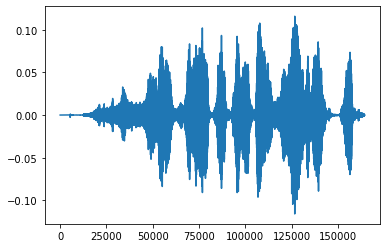

In [50]:
# plt.plot(x_n_np)

#### Model denoised audio waveform ####

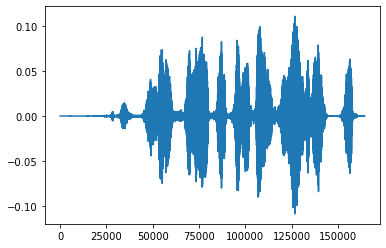

In [51]:
# plt.plot(x_est_np)

#### True clean audio waveform ####

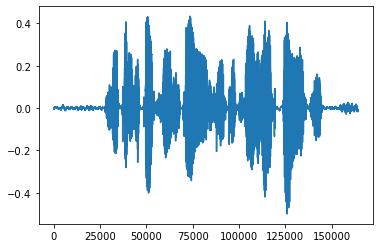

In [52]:
# plt.plot(x_c_np)

#### Save Recently Denoised Speech Files ####

In [55]:
# import IPython.display as ipd
# ipd.Audio(x_est_np, rate=48000)

In [54]:
# noise_addition_utils.save_audio_file(np_array=x_est_np,file_path=Path("Samples/denoised.wav"), sample_rate=SAMPLE_RATE, bit_precision=16)
# noise_addition_utils.save_audio_file(np_array=x_c_np,file_path=Path("Samples/clean.wav"), sample_rate=SAMPLE_RATE, bit_precision=16)
# noise_addition_utils.save_audio_file(np_array=x_n_np,file_path=Path("Samples/noisy.wav"), sample_rate=SAMPLE_RATE, bit_precision=16)